# Building embeddings from our corpus

Now we have our corpus, we can build our embeddings.

There are different types of embeddings. At our corpus we will work with word embeddings. However we could think of sentence embeddings, paragraph embeddings, document embeddings, even character or subword embeddings.

Word embeddings are vector representations of words. They are useful for many NLP tasks, such as sentiment analysis, text classification, and machine translation. They are also useful for visualising the relationships between words. For example, we can use them to find words with similar meanings, or to find words that are often used together.

## Why do we need embeddings?

Computers and most machine learning algorithms in particular work better with numerical data. However, words are not numbers. So we need to find a way to represent words as numbers.

Large Language Models such as ChatGPT also use word embeddings to represent words. However, they are trained on huge amounts of data, and so are not always suitable for smaller projects. In this notebook, we will build our own word embeddings from our corpus.

## Different types of embedddings

There are different types of word embeddings as well, such as:

- Bag of Words converted to numeric vectors
- TF-IDF converted to numeric vectors
- Word2Vec
- GloVe
- FastText
- BERT

 We will  also use the gensim library to do this. Gensim is a library for topic modelling, document indexing and similarity retrieval with large corpora. It uses the word2vec algorithm to create vector representations of words, which can then be used to find words with similar meanings.

In [1]:
# We will be using the same dataset as in the previous notebook
# usual standard imports
from pathlib import Path
from datetime import datetime

#python version
import sys
print("Python ver:", sys.version)


import pandas as pd
# print version
print("Pandas ver:", pd.__version__)

# we will need gensim for word2vec embeddings
import gensim
# print version
print("Gensim ver:", gensim.__version__)

# we will need scikit learn for tfidf embeddings
import sklearn
# print version
print("Scikit learn ver:", sklearn.__version__)

Python ver: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
Pandas ver: 2.2.2
Gensim ver: 4.3.3
Scikit learn ver: 1.5.0


## Loading Data from Parquet Url

In [2]:
# now let's load parquet file directly from url
url = "https://github.com/ValRCS/BSSDH_2024_workshop/raw/main/data/old_bailey_sample_1720_1913_cleaned.parquet"
df = pd.read_parquet(url)
# instead url i could have used local path
print("Dataframe shape:", df.shape)

Dataframe shape: (1637, 9)


In [3]:
# how much memory does this dataframe use?
print("Dataframe size:", df.memory_usage(deep=True).sum())
# supposedly Pandas 2.0 has better memory management for strings


Dataframe size: 5664174


In [4]:
# let's get some statistics about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 1720 to 1913
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   trial_number        1637 non-null   int64 
 1   punishment          1162 non-null   object
 2   text                1637 non-null   object
 3   dirty_len           1637 non-null   int64 
 4   clean_len           1637 non-null   int64 
 5   words               1637 non-null   object
 6   word_count          1637 non-null   int64 
 7   word_count_cleaned  1637 non-null   int64 
 8   words_lemmatized    1637 non-null   object
dtypes: int64(5), object(4)
memory usage: 127.9+ KB


In [5]:
# we can get basic statistics about our dataframe
df.describe() # for numerical columns - returns a dataframe as well

,trial_number,dirty_len,clean_len,word_count,word_count_cleaned
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,49.329872,3227.827734,3091.967013,608.543677,257.531460
std,34.327506,7288.101079,7020.877032,1376.101195,544.264694
min,1.000000,57.000000,51.000000,10.000000,6.000000
25%,22.000000,302.000000,285.000000,50.000000,31.000000
50%,44.000000,1359.000000,1291.000000,245.000000,115.000000
75%,70.000000,3453.000000,3299.000000,654.000000,277.000000
max,173.000000,161044.000000,156144.000000,29928.000000,11270.000000


In [6]:
# random sample of 5 rows
# let's set seed first
import numpy as np
np.random.seed(2023) # so we will get the same results
df.sample(5)

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized
year,,,,,,,,,
1896,37,Eighteen Months' Hard Labour.,95 john leigh 40 unlawfully obtaining from wal...,18027,17288,"[95, john, leigh, 40, unlawfully, obtaining, w...",3237,1466,"[95, john, leigh, 40, unlawfully, obtain, walt..."
1841,71,Confined Three Months,368 john johnson was indicted for stealing on ...,192,179,"[368, john, johnson, indicted, stealing, 9th, ...",34,23,"[368, john, johnson, indict, steal, 9th, decem..."
1762,19,None,107 m eleanor coshee otherwise southwall late ...,3708,3544,"[107, m, eleanor, coshee, southwall, late, par...",704,312,"[107, m, eleanor, coshee, southwall, late, par..."
1835,2,DEATH,186 josiah allen was indicted for burglariousl...,3395,3260,"[186, josiah, allen, indicted, burglariously, ...",655,275,"[186, josiah, allen, indict, burglariously, br..."
1731,49,[Transportation. See summary.],william simpson of st jamess clerkenwell was i...,3557,3428,"[william, simpson, st, jamess, clerkenwell, in...",667,261,"[william, simpson, st, jamess, clerkenwell, in..."


<Axes: >

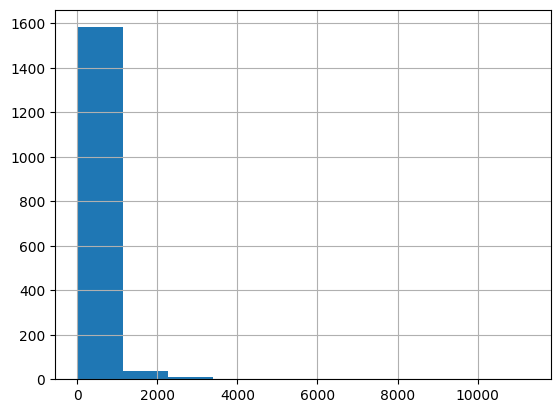

In [7]:
# we might want to plot histogram of word_count_cleaned
# this will give us a more detailed view of the distribution of word counts
df.word_count_cleaned.hist() # this will plot histogram of word counts 

In [8]:
# looks like we have some outliers, let's see what they are
df[df.word_count_cleaned > 10000]
# looks like there was a very long trial that ended up badly for the defendant

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized
year,,,,,,,,,
1872,1,DEATH,117 john selby watson 67 was indicted for the ...,161044,156144,"[117, john, selby, watson, 67, indicted, wilfu...",29928,11270,"[117, john, selby, watson, 67, indict, wilful,..."


<Axes: >

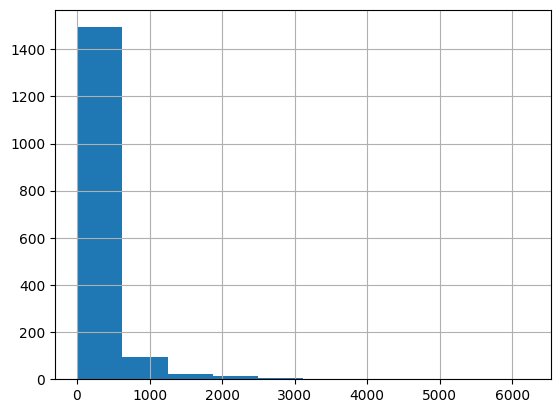

In [9]:
# for our histogram we will skip this outlier
# so we want all rows which have word_count_cleaned < 10000
df[df.word_count_cleaned < 10000].word_count_cleaned.hist()

<Axes: >

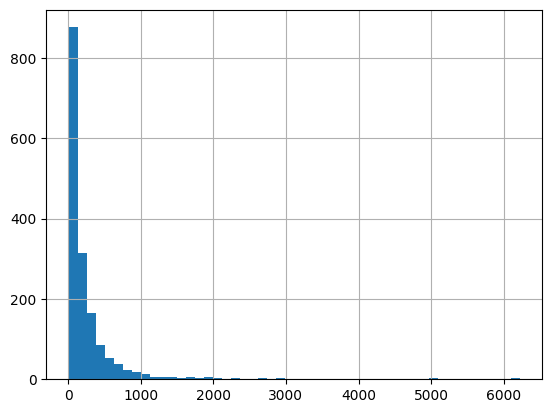

In [10]:
# we are still not getting a good view of the distribution
# let's increase the number of bins
df[df.word_count_cleaned < 10000].word_count_cleaned.hist(bins=50)


<Axes: >

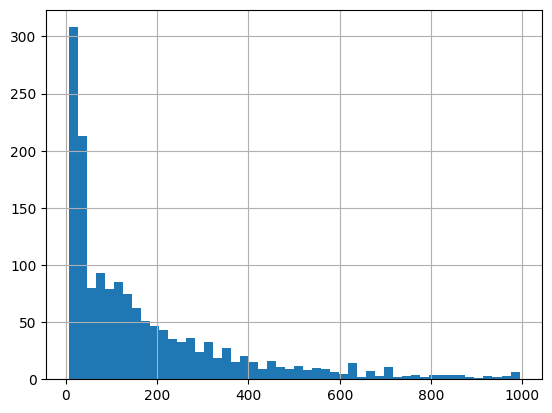

In [11]:
# again we can see that most of the documents are short
# certainly Justice in England was swift and brutal

# let's see distribution among shorter documents of less than 1000 words
df[df.word_count_cleaned < 1000].word_count_cleaned.hist(bins=50)

In [13]:
# let's look at rows that have word count cleaned less than 10
df[df.word_count_cleaned < 10].shape

(11, 9)

<Axes: >

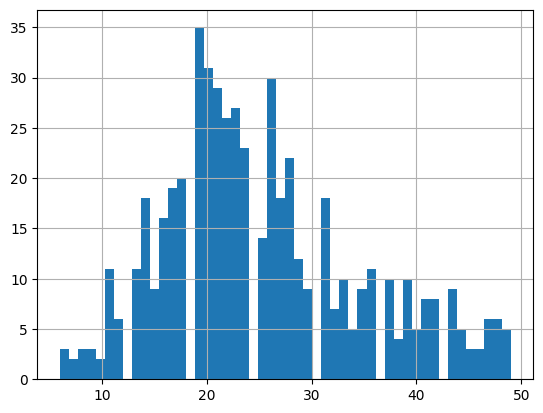

In [14]:
# let's look at a histogram of word counts for documents that have less than 50 words
# let's use use bins=50
df[df.word_count_cleaned < 50].word_count_cleaned.hist(bins=50)

<Axes: ylabel='Density'>

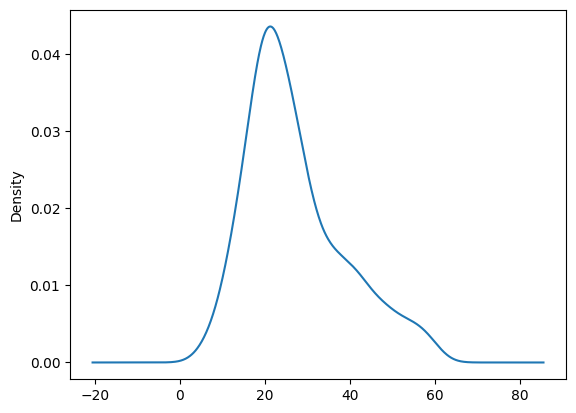

In [15]:
# lets create a kernel density plot of word count cleaned for documents with less than 60 words
df[df.word_count_cleaned < 60].word_count_cleaned.plot.kde()

<Axes: >

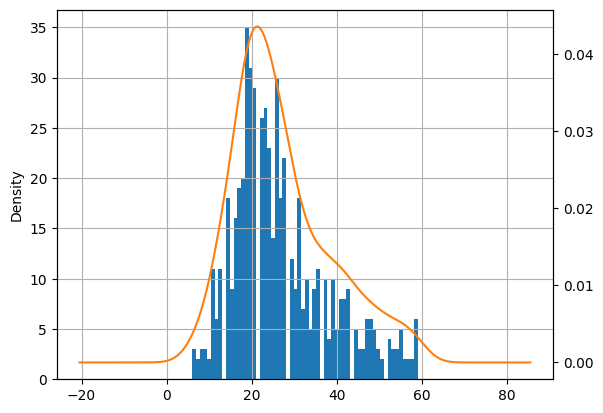

In [17]:
# let's plot both histogram and kernel density plot on the same plot for documents with less than 60 words
# let's use secondary y axis
ax = df[df.word_count_cleaned < 60].word_count_cleaned.hist(bins=60)
df[df.word_count_cleaned < 60].word_count_cleaned.plot.kde(secondary_y=True, ax=ax)



## Concerns on short texts

Short texts might not have enough information to build good embeddings. However, we will try to build them anyway.

In [12]:
# I am concerned that we will not get very useful embeddings from the very short documents but for now we will leave them in

# Also I noticed that our cleaning still left numerical digits in the text
# sometimes they are important, but in general we can remove them

In [18]:
"Valdis".isdigit() # False

False

In [14]:
"123456".isdigit() # True

True

In [19]:
# let's remove digits from our words_lemmatized column that contains list of wordsd
# let's build a function that will remove any digits in from a list of words
def remove_digits(words):
    """Removes digits from a list of words"""
    return [word for word in words if not word.isdigit()]
# let's apply it to our dataframe
df.words_lemmatized = df.words_lemmatized.apply(remove_digits)
# let's make a column with word count after removing digits
df["word_count_cleaned_no_digits"] = df.words_lemmatized.apply(len)
# let's see how many documents we have now
df.shape
# how many words did we remove?
print("Words removed with digits only:", df.word_count_cleaned.sum() - df.word_count_cleaned_no_digits.sum())
# total words remaining
print("Total words remaining:", df.word_count_cleaned_no_digits.sum())
# this will make our embeddings smaller and faster to train

Words removed with digits only: 12700
Total words remaining: 408879


In [16]:
import string
digits = string.digits
print(digits) # this is a string
print(string.ascii_letters) # this is a string
table = str.maketrans("", "", digits)
table

0123456789
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


{48: None,
 49: None,
 50: None,
 51: None,
 52: None,
 53: None,
 54: None,
 55: None,
 56: None,
 57: None}

In [21]:
def remove_digits_from_words(words):
    """Removes digits from individual words in a list of words"""
    # we need a translation table
    import string
    digits = string.digits
    # we need to make a translation table
    # we will replace digits with empty string
    table = str.maketrans("", "", digits)
    return [word.translate(table) for word in words] # this could potentially leave empty strings in our list of words

# let's test it
remove_digits_from_words(["123", "abc", "456", "Valdis2024", "2020BSSDH2024"])

['', 'abc', '', 'Valdis', 'BSSDH']

In [22]:
# we might still have words that contain a digit in them let's remove those as well
# let's build a function that will remove any words that contain digits
def remove_words_with_digits(words):
    """Removes words that contain digits from a list of words"""
    return [word for word in words if not any(char.isdigit() for char in word)] # this is slower but more general that previous function

# so using this approach John2 will be removed but not John

# let's apply it to our dataframe
# start of timer
start = datetime.now()
print(f"Start time: {start}")
df.words_lemmatized = df.words_lemmatized.apply(remove_words_with_digits)
#if i wanted to save results in a new column i would do this
#df["words_lemmatized_no_digits"] = df.words_lemmatized.apply(remove_words_with_digits)
print(f"Time elapsed: {datetime.now() - start}")
# let's update our word count cleaned no digits column
df["word_count_cleaned_no_digits"] = df.words_lemmatized.apply(len)
# let's see how many documents we have now
print("Documents:", df.shape[0])
# how many words did we remove?
print("Words removed with digits only:", df.word_count_cleaned.sum() - df.word_count_cleaned_no_digits.sum())
# total words remaining
print("Total words remaining:", df.word_count_cleaned_no_digits.sum())

Start time: 2024-07-24 11:56:34.256359
Time elapsed: 0:00:00.483611
Documents: 1637
Words removed with digits only: 19435
Total words remaining: 402144


## Bag of Words

The simplest way to build embeddings is to use a bag of words model. This is a simple model that counts the number of times each word appears in a document. It then uses these counts to build a vector representation of the document.

We will use the gensim library to build our embeddings. Gensim is a library for topic modelling, document indexing and similarity retrieval with large corpora. It uses the word2vec algorithm to create vector representations of words, which can then be used to find words with similar meanings.

In [23]:
# let's show first 5 rows of our dataframe
df.head()

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits
year,,,,,,,,,,
1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60
1720,2,Transportation,alice jones of st michaels cornhill was indict...,1087,1053,"[alice, jones, st, michaels, cornhill, indicte...",200,87,"[alice, jones, st, michaels, cornhill, indict,...",82
1720,3,Transportation,james wilson of st katharine coleman was indic...,904,883,"[james, wilson, st, katharine, coleman, indict...",177,79,"[james, wilson, st, katharine, coleman, indict...",71
1720,4,Transportation,james mercy alias masse of st andrew undershaf...,804,778,"[james, mercy, alias, masse, st, andrew, under...",143,67,"[james, mercy, alias, masse, st, andrew, under...",64
1720,5,Transportation,benjamin cook alias richard smith of st mary a...,483,466,"[benjamin, cook, alias, richard, smith, st, ma...",88,46,"[benjamin, cook, alias, richard, smith, st, ma...",43


In [24]:
# we can use scikit learn count vectorizer to get a bag of words representation
from sklearn.feature_extraction.text import CountVectorizer

# now we will use CountVectorizer to get a bag of words representation

# we will use the words_lemmatized column
# we will use the default tokenizer
# we will use the default vocabulary
# we will use the default ngram_range

# let's create an instance of CountVectorizer
count_vectorizer = CountVectorizer() # there area many custom parameters we can set, but we will use defaults for now
# if you check the documentation you will see that many of the tasks we did previously can be done with CountVectorizer such as tokenization, stopword removal, etc.
# docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# let's fit it to our words_lemmatized column
# we will need to convert it back to a string with space separated words
# we can use apply and join to do this
count_vectorizer.fit(df.words_lemmatized.apply(" ".join)) # fit is often used in scikit learn to learn the vocabulary, fit is also used in training models
# above might seem a bit wasteful, but it is a common pattern in scikit learn

# let's see what we have in our vocabulary
# how many unique words do we have?
print("Word count in bow vectorizer", len(count_vectorizer.vocabulary_)) # this will return a dictionary with words as keys and their index as values
# first 20 words
list(count_vectorizer.vocabulary_.items())[:20]# this will return a dictionary with words as keys and their index as values

Word count in bow vectorizer 18093


[('st', 15191),
 ('leonard', 9450),
 ('eastcheap', 5131),
 ('indict', 8306),
 ('feloniously', 5881),
 ('steal', 15305),
 ('pound', 12590),
 ('weight', 17460),
 ('tobacco', 16298),
 ('value', 16988),
 ('good', 6844),
 ('job', 8747),
 ('wick', 17671),
 ('dwelling', 5084),
 ('house', 7957),
 ('say', 14094),
 ('april', 626),
 ('appear', 583),
 ('prisoner', 12747),
 ('prosecutor', 12842)]

In [25]:
type(count_vectorizer.vocabulary_) # this is a dictionary

dict

In [26]:
# how many unique words do we have?
len(count_vectorizer.vocabulary_)

18093

In [27]:
# can we get a bag of words representation for a single document?
# let's get the first document
# get words from first row
first_doc = df.words_lemmatized.iloc[0] # iloc is used to get row by numerical index
# let's see what it looks like
print(first_doc)
print(len(first_doc))
# assert False quick way to stop execution of code

['st', 'leonard', 'eastcheap', 'indict', 'feloniously', 'steal', 'pound', 'weight', 'tobacco', 'value', 'l', 's', 'good', 'job', 'wick', 'dwelling', 'house', 'say', 'job', 'wick', 'april', 'appear', 'prisoner', 'prosecutor', 'servant', 'fellow', 'servant', 'depose', 'perceive', 'pocket', 'stick', 'search', 'find', 'paper', 'tobacco', 'worth', 'd', 'own', 'master', 'take', 'cellar', 'constable', 'depose', 'confest', 'take', 'tobacco', 'time', 'say', 'paper', 'tobacco', 'produce', 'court', 'jury', 'consider', 'matter', 'find', 'guilty', 'value', 'd', 'transportation']
60


In [31]:
# let's see how many unique words are in first document
print("Unique words in first document", len(set(first_doc))) # this will give us a set of unique words in the document

Unique words in first document 47


In [28]:
# our first document
" ".join(first_doc)

'st leonard eastcheap indict feloniously steal pound weight tobacco value l s good job wick dwelling house say job wick april appear prisoner prosecutor servant fellow servant depose perceive pocket stick search find paper tobacco worth d own master take cellar constable depose confest take tobacco time say paper tobacco produce court jury consider matter find guilty value d transportation'

In [29]:
# let's get bag of words representation of first document
first_doc_bow = count_vectorizer.transform([" ".join(first_doc)]) # we need to pass a list of documents
# this will return a sparse matrix
first_doc_bow

<1x18093 sparse matrix of type '<class 'numpy.int64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [30]:
# print element indexes of sparse matrix
print(first_doc_bow.indices)
# sparse matrix is a matrix that has many zero elements so those are generally not stored and are skipped

[  583   626  2732  3513  3577  3595  3837  4445  5084  5131  5870  5881
  5983  6844  7090  7957  8306  8747  8860  9450 10216 10239 11682 11770
 12050 12408 12590 12747 12786 12842 14094 14233 14364 15191 15305 15356
 15847 16262 16298 16468 16988 17460 17671 17956]


In [32]:
# let me show how you could remove short words from a list
def remove_short_words(words, min_len = 2):
    return [word for word in words if len(word) >= min_len]

# let's test it
remove_short_words(["a", "ab", "abc", "abcd", "abcde"], min_len=3)

['abc', 'abcd', 'abcde']

In [33]:
# what are those words from indices?
# we can use get_feature_names method
first_bag = count_vectorizer.get_feature_names_out()[first_doc_bow.indices]
first_bag

# note get_features_names was depreceated in favor of get_feature_names_out

# now results show that we have the same words as in our first document except the order is different
# here it looks like we have a bag of words representation for a single document in our corpus in an ordered list of words by lexical order

array(['appear', 'april', 'cellar', 'confest', 'consider', 'constable',
       'court', 'depose', 'dwelling', 'eastcheap', 'fellow',
       'feloniously', 'find', 'good', 'guilty', 'house', 'indict', 'job',
       'jury', 'leonard', 'master', 'matter', 'own', 'paper', 'perceive',
       'pocket', 'pound', 'prisoner', 'produce', 'prosecutor', 'say',
       'search', 'servant', 'st', 'steal', 'stick', 'take', 'time',
       'tobacco', 'transportation', 'value', 'weight', 'wick', 'worth'],
      dtype=object)

In [27]:
# we could create a huge sparse matrix for each document in our corpus
# however that would not be particularly useful
# we already saw that most of the words in our vocabulary are quite rare

# armed with these embbeddings we could compare documents by things like jaccard similarity
# jackquard similarity is a measure of how similar two sets are
# we could also use cosine similarity but that is a bit more complicated for now

# luckily we have many more options for creating embeddings beyond bag of words

In [34]:
# let me get second document
second_doc = df.words_lemmatized.iloc[1]
second_bow = count_vectorizer.transform([" ".join(second_doc)])
second_bag = count_vectorizer.get_feature_names_out()[second_bow.indices]
second_bag

array(['agreed', 'alice', 'april', 'askd', 'bermundas',
       'bishopsgatestreet', 'call', 'character', 'coach', 'come',
       'consider', 'cornhill', 'country', 'deny', 'depose', 'deposed',
       'edward', 'evidence', 'fact', 'fall', 'fetch', 'fetcht', 'find',
       'france', 'give', 'go', 'good', 'guilty', 'hardly', 'hat',
       'hillior', 'house', 'indict', 'indictment', 'jones', 'jury',
       'justice', 'kingstreet', 'leg', 'livd', 'master', 'matter',
       'mention', 'michaels', 'perceive', 'person', 'petticoat', 'petty',
       'price', 'prisner', 'prisoner', 'privately', 'prosecutors', 'rent',
       'reputation', 'say', 'see', 'servant', 'shew', 'shop', 'st',
       'steal', 'stop', 'tell', 'transportation', 'value', 'walk',
       'westminster', 'year'], dtype=object)

In [35]:
# we could compare these two documents by jaccard similarity
# jaccard similarity is a measure of how similar two sets are
# formula is |A intersect B| / |A union B|
# we can use set operations to do this

# wikipedia Jackquard similarity : https://en.wikipedia.org/wiki/Jaccard_index

# jacquard = len(set(first_bag).intersection(set(second_bag))) / len(set(first_bag).union(set(second_bag)))
# jacquard

# we could make our own function to do this
def jaccard_similarity(first_bag, second_bag):
    """Calculates jaccard similarity between two bags of words"""
    return len(set(first_bag).intersection(set(second_bag))) / len(set(first_bag).union(set(second_bag)))

# let's test it
jaccard_similarity(first_bag, second_bag)

0.20212765957446807

In [ ]:
# so with jaccard the minimum is 0 and maximum is 1
# 1 would signify that two documents are identical
# while 0 would signify that two documents have no words in common whatsoever

# downside to jaccard is that it does not take into account the frequency of words
# another downside is that for large corpora it can be quite slow because we have to go through all unique words in both documents

## TF-IDF embeddings

TF-IDF is a widely used technique for text analysis. It stands for term frequency-inverse document frequency. It is a way of measuring how important a word is to a document in a collection of documents. It is often used to find keywords in a document.

TF-IDF consists of two parts: term frequency and inverse document frequency. Term frequency is the number of times a word appears in a document, while inverse document frequency is the number of documents in a collection that contain a word. The TF-IDF score is the product of these two numbers.

The idea is that first part - TF - is the number of times a word appears in a document, and the bottom part - IDF - is the number of documents in a collection that contain a word. The TF-IDF score is the product of these two numbers.

If IDF is high - this means the word is not particularly common in the collection of documents. If TF is high - this means the word is common in the document. So if a word is common in a document, but not common in the collection of documents, it will have a high TF-IDF score - ergo this word is common to the document, but not common to the collection of documents.

In [36]:
# we can use tfidf to create embeddings

# scikit learn has a tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# let's create an instance of tfidf vectorizer
# tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer() # there area many custom parameters we can set, but we will use defaults for now
tfidf_vectorizer = TfidfVectorizer() # there area many custom parameters we can set, but we will use defaults for now

In [37]:
# let's create tfidf embeddings for our corpus
# we will use the words_lemmatized column

# let's fit it to our words_lemmatized column
# we will need to convert it back to a string with space separated words

# we can use apply and join to do this
tfidf_vectorizer.fit(df.words_lemmatized.apply(" ".join)) # fit is often used in scikit learn to learn the vocabulary, fit is also used in training models

# let's see what we have in our vocabulary
# how many unique words do we have?
print("Unique words:", len(tfidf_vectorizer.vocabulary_))
# first 20 words
list(tfidf_vectorizer.vocabulary_.items())[:20]# this will return a dictionary with words as keys and their index as values

Unique words: 18093


[('st', 15191),
 ('leonard', 9450),
 ('eastcheap', 5131),
 ('indict', 8306),
 ('feloniously', 5881),
 ('steal', 15305),
 ('pound', 12590),
 ('weight', 17460),
 ('tobacco', 16298),
 ('value', 16988),
 ('good', 6844),
 ('job', 8747),
 ('wick', 17671),
 ('dwelling', 5084),
 ('house', 7957),
 ('say', 14094),
 ('april', 626),
 ('appear', 583),
 ('prisoner', 12747),
 ('prosecutor', 12842)]

In [38]:
# Those attentive  have noticed that both bow and tfidf vectorizers have the same vocabulary, which makes sense as we used same data to fit them
# also we used same hyper parameters for fitting so they should be the same 
# in this case we used default hyper parameters - which means we only used unigrams

# now let's create tifidf embeddings for our corpus

# we will use the transform method

# let's get the first document
# get words from first row
first_doc = df.words_lemmatized.iloc[0] # iloc is used to get row by numerical index
# let's see what it looks like
# show tfidf embeddings for first document
sparse_tfidf_first_doc = tfidf_vectorizer.transform([" ".join(first_doc)])

# print element indexes of sparse matrix
print(sparse_tfidf_first_doc.indices)


[  583   626  2732  3513  3577  3595  3837  4445  5084  5131  5870  5881
  5983  6844  7090  7957  8306  8747  8860  9450 10216 10239 11682 11770
 12050 12408 12590 12747 12786 12842 14094 14233 14364 15191 15305 15356
 15847 16262 16298 16468 16988 17460 17671 17956]


In [39]:
# compare indices of tfidf and bow
common_indices = set(first_doc_bow.indices).intersection(set(sparse_tfidf_first_doc.indices))
print("Common indices:", common_indices)
# length of common indices and length of tfidf indices and bow indices
print("Common indices:", len(common_indices), len(sparse_tfidf_first_doc.indices), len(first_doc_bow.indices))

Common indices: {16262, 17671, 5131, 3595, 14094, 12050, 7957, 14233, 14364, 8860, 11682, 17956, 12842, 8747, 2732, 16298, 12590, 7090, 17460, 3513, 6844, 583, 15305, 12747, 3577, 16468, 15191, 5084, 4445, 16988, 5983, 15847, 10216, 9450, 5870, 626, 8306, 12786, 12408, 5881, 11770, 15356, 3837, 10239}
Common indices: 44 44 44


In [40]:
# well the indices are all common,but bag of words either has count for word or not
# tfidf has a value for each word which indicates how important that word is for that document
# let's print those values for first doc
print(sparse_tfidf_first_doc.data)

[0.08560634 0.10001348 0.13877142 0.19723912 0.11371992 0.07788469
 0.07063989 0.21576343 0.1396641  0.18583865 0.12566637 0.06070487
 0.09419189 0.04642964 0.03137085 0.05520719 0.03752959 0.26499458
 0.05287715 0.16007528 0.08108325 0.10184287 0.12918558 0.18846137
 0.15061469 0.07474145 0.09590149 0.03825868 0.06048691 0.06912378
 0.08669131 0.07622164 0.1623928  0.0725742  0.03811135 0.12253903
 0.0880047  0.05984298 0.54500717 0.09667718 0.09338854 0.1152001
 0.37167729 0.0976779 ]


In [41]:
max(sparse_tfidf_first_doc.data) # this is the maximum tfidf value for this document

0.5450071694542095

In [42]:
# what are most important words for first document?
# let's get indices of top 10 most important words
top_10_indices = np.argsort(sparse_tfidf_first_doc.data)[-10:]
print(top_10_indices)
# now these are indices of top 10 most important words

[24 19 32  9 23  3  7 17 42 38]


In [43]:
# top 10 most important words values
print(sparse_tfidf_first_doc.data[top_10_indices])

[0.15061469 0.16007528 0.1623928  0.18583865 0.18846137 0.19723912
 0.21576343 0.26499458 0.37167729 0.54500717]


In [44]:
# let's print word indexes for these top 10 words
top_10_word_indexes = sparse_tfidf_first_doc.indices[top_10_indices]
print(top_10_word_indexes)

[12050  9450 14364  5131 11770  3513  4445  8747 17671 16298]


In [45]:
tfidf_vectorizer.get_feature_names_out()[top_10_word_indexes]

array(['perceive', 'leonard', 'servant', 'eastcheap', 'paper', 'confest',
       'depose', 'job', 'wick', 'tobacco'], dtype=object)

In [46]:
# that is not so nice looking so we can zip them together
# list(zip(tfidf_vectorizer.get_feature_names_out()[top_10_indices], sparse_tfidf_first_doc.data[top_10_indices]))
# print them in a nicer way
top_10_word_indexes = sparse_tfidf_first_doc.indices[top_10_indices]
for word, tfidf in zip(tfidf_vectorizer.get_feature_names_out()[top_10_word_indexes], sparse_tfidf_first_doc.data[top_10_indices]):
    print(word, tfidf)

perceive 0.150614686372503
leonard 0.16007528280052968
servant 0.16239279925933367
eastcheap 0.18583864714836273
paper 0.18846136671056873
confest 0.19723911748724512
depose 0.21576343212843105
job 0.264994575194677
wick 0.37167729429672547
tobacco 0.5450071694542095


In [41]:
# we can see that tfidf embeddings are much more informative than bag of words embeddings
# we can find the most important words for each document
# tfidf is great because it will automatically filter out stopwords and rare words
# using scikit learn indexing can get pretty tricky though

In [47]:
# let's get top 5 words for each document
# we will need to iterate over each document
# we will need to get tfidf embeddings for each document

# let's create a function that will return top n words for a document
def get_top_n_words(document, n=5):
    """Returns top n words for a document"""
    # get tfidf embeddings for document
    # TODO pass tfidf_vectorizer as parameter to avoid global variable
    sparse_tfidf_doc = tfidf_vectorizer.transform([" ".join(document)])
    # get indices of top n words
    top_n_indices = np.argsort(sparse_tfidf_doc.data)[-n:]
    # get word indexes for top n words
    top_n_word_indexes = sparse_tfidf_doc.indices[top_n_indices]
    # get top n words
    top_n_words = tfidf_vectorizer.get_feature_names_out()[top_n_word_indexes]
    # get top n tfidf values
    top_n_tfidf = sparse_tfidf_doc.data[top_n_indices]
    # return top n words and top n tfidf values
    return list(zip(top_n_words, top_n_tfidf))

# let's test it on first document
get_top_n_words(first_doc)

[('confest', 0.19723911748724512),
 ('depose', 0.21576343212843105),
 ('job', 0.264994575194677),
 ('wick', 0.37167729429672547),
 ('tobacco', 0.5450071694542095)]

In [48]:
# let's do it for second document and get top 10 words
second_doc = df.words_lemmatized.iloc[1]
get_top_n_words(second_doc, n=10)


[('cornhill', 0.15884808501366063),
 ('prisner', 0.17961123347931332),
 ('petty', 0.17961123347931332),
 ('michaels', 0.17961123347931332),
 ('fetcht', 0.18697707761950694),
 ('shop', 0.18964859164396325),
 ('bermundas', 0.19735865185233328),
 ('hillior', 0.19735865185233328),
 ('agreed', 0.19735865185233328),
 ('hat', 0.39621153198799697)]

In [49]:
# now we can apply it to our dataframe
# we will use apply method
# we will use lambda function

# start of timer
start = datetime.now()
print(f"Start time: {start}")
# df["top_5_words_tfidf"] = df.words_lemmatized.apply(lambda x: get_top_n_words(x, n=10))
# i am using lambda to pass a specific value for n
# here I could have gotten away with just passing get_top_n_words without lambda because n is the default value
# like this
# so next example shows how to pass a specific value for n
df["top_10_words_tfidf"] = df.words_lemmatized.apply(get_top_n_words,(10,)) 
print(f"Time elapsed: {datetime.now() - start}")
# print shape
df.shape

Start time: 2024-07-24 12:27:40.450278


C:\Users\val-wd\AppData\Local\Temp\ipykernel_10376\445162352.py:12: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df["top_10_words_tfidf"] = df.words_lemmatized.apply(get_top_n_words,(10,))


Time elapsed: 0:00:38.228945


(1637, 11)

In [44]:
# let's see what we have
df.sample(5)[['top_10_words_tfidf']] # note the double brackets this gives you dataframe instead of series

,top_5_words_tfidf
year,
1902,"[(office, 0.18194225183146615), (book, 0.25306..."
1841,"[(coal, 0.19814038693423272), (charlotte, 0.21..."
1902,"[(herbert, 0.3214283443450827), (manslaughter,..."
1865,"[(lung, 0.18396441631576374), (food, 0.1896795..."
1814,"[(see, 0.17690868106143018), (step, 0.17693100..."


In [52]:
# let's do head again
df.head()

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_10_words_tfidf
year,,,,,,,,,,,
1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60,"[(confest, 0.19723911748724512), (depose, 0.21..."
1720,2,Transportation,alice jones of st michaels cornhill was indict...,1087,1053,"[alice, jones, st, michaels, cornhill, indicte...",200,87,"[alice, jones, st, michaels, cornhill, indict,...",82,"[(shop, 0.18964859164396325), (bermundas, 0.19..."
1720,3,Transportation,james wilson of st katharine coleman was indic...,904,883,"[james, wilson, st, katharine, coleman, indict...",177,79,"[james, wilson, st, katharine, coleman, indict...",71,"[(hung, 0.21832648950390215), (deposed, 0.2419..."
1720,4,Transportation,james mercy alias masse of st andrew undershaf...,804,778,"[james, mercy, alias, masse, st, andrew, under...",143,67,"[james, mercy, alias, masse, st, andrew, under...",64,"[(masse, 0.2126517359898944), (undershaft, 0.2..."
1720,5,Transportation,benjamin cook alias richard smith of st mary a...,483,466,"[benjamin, cook, alias, richard, smith, st, ma...",88,46,"[benjamin, cook, alias, richard, smith, st, ma...",43,"[(stopt, 0.23416420335477436), (abchurch, 0.26..."


In [50]:
# let's see what we really have
df.sample(5)[['top_10_words_tfidf']]

,top_10_words_tfidf
year,
1902,"[(office, 0.18194225183146615), (book, 0.25306..."
1841,"[(coal, 0.19814038693423272), (charlotte, 0.21..."
1902,"[(herbert, 0.3214283443450827), (manslaughter,..."
1865,"[(lung, 0.18396441631576374), (food, 0.1896795..."
1814,"[(see, 0.17690868106143018), (step, 0.17693100..."


In [51]:
df.columns

Index(['trial_number', 'punishment', 'text', 'dirty_len', 'clean_len', 'words',
       'word_count', 'word_count_cleaned', 'words_lemmatized',
       'word_count_cleaned_no_digits', 'top_10_words_tfidf'],
      dtype='object')

In [53]:
df.sample(5)[['top_10_words_tfidf', 'word_count_cleaned', 'word_count_cleaned_no_digits']] # so 3 columns in any order

,top_10_words_tfidf,word_count_cleaned,word_count_cleaned_no_digits
year,,,
1902,"[(prisoner, 0.1678846871306937), (shot, 0.2407...",630,608
1865,"[(page, 0.2688358847960135), (robinson, 0.2725...",24,21
1773,"[(fox, 0.29931349659777884), (silver, 0.339855...",27,22
1881,"[(original, 0.2666105486026002), (image, 0.278...",25,19
1881,"[(josiah, 0.27682582893519736), (jessie, 0.283...",32,27


In [54]:
# we would love to save our data to parquet file but alas we have datatypes that are not supported by parquet
# thus we will use pickle that will faithfully save everything
# we will use to_pickle method
# we will use compression to save space
# start of timer
start = datetime.now()
pickle_file = Path("old_bailey_sample_1720_1913_cleaned_embeddings.pkl") # will save in current folder not in data folder
print(f"Start time: {start}")
df.to_pickle(pickle_file, compression="zip") # just regular zip compression not related to zip in python loops
print(f"Time elapsed: {datetime.now() - start}")
# how big is our file?
print("File size:", pickle_file.stat().st_size)
# not too bad a compression ratio and we kept all our data and datatypes


Start time: 2024-07-24 12:32:37.248990
Time elapsed: 0:00:01.847934
File size: 3319507


In [55]:
# getting memory usage for dataframe
df.memory_usage(deep=True).sum()
# deep might be a recent addition to pandas

9235442

In [49]:
# 4 bytes would be 32 bits
# enough for
2**32 # 4 294 967 296 - 4gb memory

4294967296

In [50]:
# 64 bits 
2**64 # 18 446 744 073 709 551 616 - 18 exabytes

18446744073709551616

In [51]:
# generic python list will take quite a bit of memory
# let me store 100 Milllion integers in a list
big_nums = list(range(100_000_000))

In [52]:
big_nums = list(range(10)) # not so big # so big numbers will be garbage collected by Python
big_nums 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## word2vec embeddings

word2vec embeddings is a technique for creating word embeddings. It is a neural network model that takes a word as input and outputs a vector representation of that word. The word2vec model is trained on a large corpus of text, and learns to predict the context of a word based on its vector representation.

word2vec came to prominence in 2013, when Google released a paper describing the model. It has since been used in many applications, including machine translation, sentiment analysis, and text classification.

Original Google paper: Efficient Estimation of Word Representations in
Vector Space https://arxiv.org/pdf/1301.3781.pdf

In [56]:
# we can use gensim to create word2vec embeddings for our whole corpus

# we will use the words_lemmatized column
# we will use the default tokenizer
# we will use the default vocabulary
# we will use the default ngram_range

# we need to use a list of lists of words
# we can use apply and split to do this
# start of timer
start = datetime.now()
print(f"Start time: {start}")
# sentences = df.words_lemmatized.apply(lambda x: x.split()).tolist() # we would use this if our words were a string separated by spaces
sentences = df.words_lemmatized.tolist()
print(f"Time elapsed: {datetime.now() - start}")
# let's see what we have
sentences[:2]

Start time: 2024-07-24 12:34:14.574800
Time elapsed: 0:00:00


[['st',
  'leonard',
  'eastcheap',
  'indict',
  'feloniously',
  'steal',
  'pound',
  'weight',
  'tobacco',
  'value',
  'l',
  's',
  'good',
  'job',
  'wick',
  'dwelling',
  'house',
  'say',
  'job',
  'wick',
  'april',
  'appear',
  'prisoner',
  'prosecutor',
  'servant',
  'fellow',
  'servant',
  'depose',
  'perceive',
  'pocket',
  'stick',
  'search',
  'find',
  'paper',
  'tobacco',
  'worth',
  'd',
  'own',
  'master',
  'take',
  'cellar',
  'constable',
  'depose',
  'confest',
  'take',
  'tobacco',
  'time',
  'say',
  'paper',
  'tobacco',
  'produce',
  'court',
  'jury',
  'consider',
  'matter',
  'find',
  'guilty',
  'value',
  'd',
  'transportation'],
 ['alice',
  'jones',
  'st',
  'michaels',
  'cornhill',
  'indict',
  'privately',
  'steal',
  'bermundas',
  'hat',
  'value',
  's',
  'shop',
  'edward',
  'hillior',
  'april',
  'prosecutors',
  'servant',
  'deposed',
  'prisner',
  'come',
  'master',
  'shop',
  'askd',
  'hat',
  's',
  'price'

In [57]:
# how many sentences do we have?
len(sentences)

1637

In [61]:
# let's feed our sentences to gensim word2vec model
# we will use default hyper parameters
# start of timer
start = datetime.now()
print(f"Start time: {start}")
w2v_model = gensim.models.Word2Vec(sentences=sentences, epochs=10)
print(f"Time elapsed: {datetime.now() - start}")
# cool think about word2vec is that it trains very fast - unlike more modern embeddings such as BERT
# let's see what we have
w2v_model

Start time: 2024-07-24 12:39:49.603193
Time elapsed: 0:00:03.327523


In [62]:
# we can now use our model to get embeddings for words
# we can compare words by similarity
# we can get most similar words

# let's try king and queen
w2v_model.wv.most_similar("king")

[('highway', 0.835797131061554),
 ('johnson', 0.7857441306114197),
 ('pauls', 0.782382607460022),
 ('queen', 0.7804726958274841),
 ('clements', 0.7612759470939636),
 ('prince', 0.76038658618927),
 ('butler', 0.7531979084014893),
 ('alias', 0.7530476450920105),
 ('churchyard', 0.7522007822990417),
 ('crickett', 0.7483892440795898)]

In [63]:
# how about queen
w2v_model.wv.most_similar("queen")

[('churchyard', 0.9438380002975464),
 ('pauls', 0.9382634162902832),
 ('oxford', 0.917610228061676),
 ('victoria', 0.9173659086227417),
 ('square', 0.9043251872062683),
 ('peterinchain', 0.9030390977859497),
 ('lambeth', 0.9015888571739197),
 ('castlestreet', 0.8997366428375244),
 ('euston', 0.8981679081916809),
 ('prince', 0.8962473273277283)]

In [ ]:
# a bit surprising but then again court transcripts seldom deal with royalty

In [65]:
# how about tobacco?
w2v_model.wv.most_similar("tobacco")

[('cake', 0.9212360382080078),
 ('loaf', 0.9049498438835144),
 ('pipe', 0.8886724710464478),
 ('butter', 0.8879395127296448),
 ('cheese', 0.8768537640571594),
 ('counter', 0.8686412572860718),
 ('ribbon', 0.8617796301841736),
 ('bacon', 0.8609875440597534),
 ('halfsovereign', 0.8505585789680481),
 ('basket', 0.8421703577041626)]

In [66]:
# how about beer?
w2v_model.wv.most_similar("beer")
# now we are talking! or drinking!

[('pint', 0.9706339836120605),
 ('drank', 0.9451059103012085),
 ('gin', 0.929814875125885),
 ('rum', 0.9210976958274841),
 ('ale', 0.9138795733451843),
 ('drink', 0.8978064656257629),
 ('water', 0.8804354071617126),
 ('quartern', 0.8618340492248535),
 ('halfapint', 0.8469358682632446),
 ('pot', 0.835966944694519)]

In [67]:
# let's get the actual vector for beer
print("Shape", w2v_model.wv["beer"].shape)
w2v_model.wv["beer"]

Shape (100,)


array([-0.20704958, -1.0188049 ,  0.7589901 ,  1.3463948 , -0.78081214,
       -0.5508044 , -0.4154636 ,  0.5938753 ,  0.8991826 ,  0.5423463 ,
       -0.75328827, -0.2646693 , -0.37275392,  0.6842783 , -0.39355528,
       -0.9859432 ,  0.60919046, -0.25134945, -0.41177657, -2.196357  ,
        1.9641587 ,  0.1062551 ,  1.1531996 , -0.0402808 ,  0.48315954,
        0.7236104 , -0.53410774,  0.14795913,  0.07646044,  1.2497494 ,
       -0.0208775 , -0.51773584, -0.08169967, -2.027364  , -0.36247703,
       -0.68623483,  0.3421864 , -0.76016766, -0.14152855, -1.24315   ,
       -1.122587  , -0.8270694 , -0.56890464, -0.338976  ,  0.3964246 ,
       -0.43062323,  0.7337306 ,  0.11415987,  1.1421694 ,  0.794361  ,
        0.69448525, -0.10535423,  0.6486222 , -0.35316145, -1.0183859 ,
        0.5835147 ,  0.07040794, -0.2787218 , -0.2978369 ,  0.90940416,
        0.01565441, -0.01230239, -0.30026245,  0.14256316, -1.278911  ,
        0.33065367,  0.3320252 ,  1.5820879 , -0.9880115 ,  1.59

In [68]:
# let's check dimensions of our sentences
print("Sentences:", len(sentences))
# how about min and max of sentence lengths
print("Min sentence length:", min([len(sentence) for sentence in sentences]))
print("Max sentence length:", max([len(sentence) for sentence in sentences]))


Sentences: 1637
Min sentence length: 5
Max sentence length: 11127


In [69]:
from tqdm import tqdm
# So word 2 vec is a great way to get embeddings for words, but we would like to get embeddings for documents
# we can do that by averaging word embeddings for each document
# but also we can use doc2vec which is an extension of word2vec

# more info: https://radimrehurek.com/gensim/models/doc2vec.html

# let's use doc2vec to get embeddings for our corpus

# we will use the words_lemmatized column

# we need to use a list of lists of words

# we already have sentences variable from previous example
# it is a list of lists
# first index represents document

# let's feed our sentences to gensim doc2vec model
# we will use default hyper parameters

# for doc2vec training data we need TaggedDocument objects
# we can use gensim TaggedDocument class to create them
# we will use apply and split to do this
# start of timer
tagged_sentences = []
start = datetime.now()
print(f"Start time: {start}")
# this will be slow as we will iterate over all documents
# so enumerate starts from 0 and adds 1 for each iteration
for i, sentence in tqdm(enumerate(sentences)):
    tagged_sentences.append(gensim.models.doc2vec.TaggedDocument(sentence, [i])) # we need to pass a list of words and a list of tags

print(f"Time elapsed: {datetime.now() - start}")

# print first 5 sentences
tagged_sentences[:5]

Start time: 2024-07-24 12:49:41.214088


1637it [00:00, 410355.94it/s]

Time elapsed: 0:00:00.011987


[TaggedDocument(words=['st', 'leonard', 'eastcheap', 'indict', 'feloniously', 'steal', 'pound', 'weight', 'tobacco', 'value', 'l', 's', 'good', 'job', 'wick', 'dwelling', 'house', 'say', 'job', 'wick', 'april', 'appear', 'prisoner', 'prosecutor', 'servant', 'fellow', 'servant', 'depose', 'perceive', 'pocket', 'stick', 'search', 'find', 'paper', 'tobacco', 'worth', 'd', 'own', 'master', 'take', 'cellar', 'constable', 'depose', 'confest', 'take', 'tobacco', 'time', 'say', 'paper', 'tobacco', 'produce', 'court', 'jury', 'consider', 'matter', 'find', 'guilty', 'value', 'd', 'transportation'], tags=[0]),
 TaggedDocument(words=['alice', 'jones', 'st', 'michaels', 'cornhill', 'indict', 'privately', 'steal', 'bermundas', 'hat', 'value', 's', 'shop', 'edward', 'hillior', 'april', 'prosecutors', 'servant', 'deposed', 'prisner', 'come', 'master', 'shop', 'askd', 'hat', 's', 'price', 'shew', 'agreed', 'say', 'country', 'stop', 'bishopsgatestreet', 'coach', 'go', 'come', 'fetch', 'go', 'shop', 'per

In [70]:
first_tagged_sentence = tagged_sentences[0]
type(first_tagged_sentence)

gensim.models.doc2vec.TaggedDocument

In [71]:
first_tagged_sentence.tags # so basically we added a tag 0

[0]

In [72]:
# now we are ready to train our doc2vec model
# start of timer
start = datetime.now()
print(f"Start time: {start}")
# so instead of default vector size of 100 we will use 50
# and instead of defaul epochs of 5 we will use 40
# and instead of default min_count of 5 we will use 2
d2v_model = gensim.models.Doc2Vec(vector_size=50, min_count=2, epochs=40)
print(f"Time elapsed: {datetime.now() - start}")
# we have created and instance of the model but we have not trained it yet


Start time: 2024-07-24 12:51:58.794637
Time elapsed: 0:00:00.001990


In [73]:
# now let's train it with our tagged sentences
# start of timer
start = datetime.now()
print(f"Start time: {start}")
d2v_model.build_vocab(tagged_sentences)
print(f"Time elapsed: {datetime.now() - start}")




Start time: 2024-07-24 12:52:14.141956
Time elapsed: 0:00:00.279199


In [74]:
# who key to index 
d2v_model.wv.key_to_index["king"], d2v_model.wv.key_to_index["queen"], d2v_model.wv.key_to_index["beer"], d2v_model.wv.key_to_index["tobacco"]

(293, 1265, 426, 669)

In [75]:
d2v_model.wv.index_to_key[293]

'king'

In [76]:
# index to key
d2v_model.wv.index_to_key[0], d2v_model.wv.index_to_key[1], d2v_model.wv.index_to_key[2], d2v_model.wv.index_to_key[3]

('say', 'prisoner', 'do', 'mr')

In [77]:
d2v_model.corpus_count # so that's how many documents we have

1637

In [78]:
# finally number of epochs we specified
d2v_model.epochs

40

In [79]:
# now we will finaly train our model
# start of timer
start = datetime.now()
print(f"Start time: {start}")
d2v_model.train(tagged_sentences, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print(f"Time elapsed: {datetime.now() - start}")


Start time: 2024-07-24 12:53:20.107621
Time elapsed: 0:00:30.425634


In [80]:
# now each document should have a corresponding vector
# let's get this vector for first document
d2v_model.dv[0] # old gensim used docvecs instead of dv
# basically we have a 50 length vector for each document
# we can use cosine similarity to compare documents and find most similar documents

array([ 0.91934407,  0.10369361, -0.47893998,  0.36896503,  0.5935016 ,
        1.0707822 ,  0.42577276,  0.58713037,  0.52633387, -0.44031435,
        0.4316449 ,  0.2217436 , -0.34043258, -0.61832774, -0.25430122,
        0.00862007, -0.834393  , -0.43783528,  0.5313231 , -0.3245354 ,
       -0.9674761 ,  0.2782799 ,  0.19714694, -0.20649123, -0.03989292,
       -0.39101386, -0.9537217 , -1.1435323 ,  0.16649729,  0.40458196,
       -0.1376205 ,  0.12284689, -0.02144223,  0.10431359,  0.3322978 ,
       -0.06357827,  0.15921514,  0.959302  , -1.0685375 , -0.14352907,
        0.05050782, -0.11962064,  0.18787526, -0.48553732,  0.44496465,
        1.2385678 , -0.13819677, -0.39829925,  0.69497836,  0.3766298 ],
      dtype=float32)

In [82]:
# how many documents do we have?
len(d2v_model.dv)

1637

In [83]:
# how many rows in our dataframe?
df.shape

(1637, 11)

In [84]:
# head 
df.head()

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_10_words_tfidf
year,,,,,,,,,,,
1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60,"[(confest, 0.19723911748724512), (depose, 0.21..."
1720,2,Transportation,alice jones of st michaels cornhill was indict...,1087,1053,"[alice, jones, st, michaels, cornhill, indicte...",200,87,"[alice, jones, st, michaels, cornhill, indict,...",82,"[(shop, 0.18964859164396325), (bermundas, 0.19..."
1720,3,Transportation,james wilson of st katharine coleman was indic...,904,883,"[james, wilson, st, katharine, coleman, indict...",177,79,"[james, wilson, st, katharine, coleman, indict...",71,"[(hung, 0.21832648950390215), (deposed, 0.2419..."
1720,4,Transportation,james mercy alias masse of st andrew undershaf...,804,778,"[james, mercy, alias, masse, st, andrew, under...",143,67,"[james, mercy, alias, masse, st, andrew, under...",64,"[(masse, 0.2126517359898944), (undershaft, 0.2..."
1720,5,Transportation,benjamin cook alias richard smith of st mary a...,483,466,"[benjamin, cook, alias, richard, smith, st, ma...",88,46,"[benjamin, cook, alias, richard, smith, st, ma...",43,"[(stopt, 0.23416420335477436), (abchurch, 0.26..."


In [85]:
# what is df.index
df.index
# looks like we started using year as index
# let's reset index by moving year to a column
df = df.reset_index() # this will move year to a column and create a new index in this case numerical
# let's see what we have
df.head()

,year,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_10_words_tfidf
0,1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60,"[(confest, 0.19723911748724512), (depose, 0.21..."
1,1720,2,Transportation,alice jones of st michaels cornhill was indict...,1087,1053,"[alice, jones, st, michaels, cornhill, indicte...",200,87,"[alice, jones, st, michaels, cornhill, indict,...",82,"[(shop, 0.18964859164396325), (bermundas, 0.19..."
2,1720,3,Transportation,james wilson of st katharine coleman was indic...,904,883,"[james, wilson, st, katharine, coleman, indict...",177,79,"[james, wilson, st, katharine, coleman, indict...",71,"[(hung, 0.21832648950390215), (deposed, 0.2419..."
3,1720,4,Transportation,james mercy alias masse of st andrew undershaf...,804,778,"[james, mercy, alias, masse, st, andrew, under...",143,67,"[james, mercy, alias, masse, st, andrew, under...",64,"[(masse, 0.2126517359898944), (undershaft, 0.2..."
4,1720,5,Transportation,benjamin cook alias richard smith of st mary a...,483,466,"[benjamin, cook, alias, richard, smith, st, ma...",88,46,"[benjamin, cook, alias, richard, smith, st, ma...",43,"[(stopt, 0.23416420335477436), (abchurch, 0.26..."


In [88]:
# let's check the type of dv2_model.dv
print(f"Type of dv2_model.dv: {type(d2v_model.dv)}")
# now type of first element
print(f"Type of first element: {type(d2v_model.dv[0])}")
# shape of first element
print(f"Shape of first element: {d2v_model.dv[0].shape}")

Type of dv2_model.dv: <class 'gensim.models.keyedvectors.KeyedVectors'>
Type of first element: <class 'numpy.ndarray'>
Shape of first element: (50,)


In [94]:
# let's assign these vectors to our dataframe
# start of timer
start = datetime.now()
print(f"Start time: {start}")
# crucially here our indexing should match our tags in tagged_sentences
df["doc2vec"] = df.index.map(lambda x: d2v_model.dv[x])
# we could skip map and just assign the whole d2v_model.dv directly since it is a
# TODO see if we can convert dv2_model.dv to a numpy array
# so our lambda function returns a corresponding vector for each index
print(f"Time elapsed: {datetime.now() - start}")
# let's see what we have
df.head()

Start time: 2024-07-24 13:01:40.101674
Time elapsed: 0:00:00.001995


,year,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_10_words_tfidf,doc2vec
0,1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60,"[(confest, 0.19723911748724512), (depose, 0.21...","[0.91934407, 0.10369361, -0.47893998, 0.368965..."
1,1720,2,Transportation,alice jones of st michaels cornhill was indict...,1087,1053,"[alice, jones, st, michaels, cornhill, indicte...",200,87,"[alice, jones, st, michaels, cornhill, indict,...",82,"[(shop, 0.18964859164396325), (bermundas, 0.19...","[-0.4580645, 0.047241077, -1.1409273, 0.387530..."
2,1720,3,Transportation,james wilson of st katharine coleman was indic...,904,883,"[james, wilson, st, katharine, coleman, indict...",177,79,"[james, wilson, st, katharine, coleman, indict...",71,"[(hung, 0.21832648950390215), (deposed, 0.2419...","[-0.52152157, 0.11271813, -0.039994188, -0.399..."
3,1720,4,Transportation,james mercy alias masse of st andrew undershaf...,804,778,"[james, mercy, alias, masse, st, andrew, under...",143,67,"[james, mercy, alias, masse, st, andrew, under...",64,"[(masse, 0.2126517359898944), (undershaft, 0.2...","[0.7243695, 0.5472455, -0.86394536, 0.5828498,..."
4,1720,5,Transportation,benjamin cook alias richard smith of st mary a...,483,466,"[benjamin, cook, alias, richard, smith, st, ma...",88,46,"[benjamin, cook, alias, richard, smith, st, ma...",43,"[(stopt, 0.23416420335477436), (abchurch, 0.26...","[-0.29857674, 0.11186821, -0.69514287, -0.0988..."


In [95]:
# let's see last 3 columns of our first 5 rows
# here we are specifying column names so the order might be off, it is our choice
df.head()[['word_count_cleaned', 'word_count_cleaned_no_digits', 'doc2vec']]

,word_count_cleaned,word_count_cleaned_no_digits,doc2vec
0,66,60,"[0.91934407, 0.10369361, -0.47893998, 0.368965..."
1,87,82,"[-0.4580645, 0.047241077, -1.1409273, 0.387530..."
2,79,71,"[-0.52152157, 0.11271813, -0.039994188, -0.399..."
3,67,64,"[0.7243695, 0.5472455, -0.86394536, 0.5828498,..."
4,46,43,"[-0.29857674, 0.11186821, -0.69514287, -0.0988..."


In [92]:
# other recipe to do the same thing using numerical indexing
# so first 5 rows and last 3 columns
df.iloc[:5, -3:]
# reminder these are not copies of dataframes but views into the original dataframe
# if you need a true copy then use copy method
head_copy = df.iloc[:5, -3:].copy() # this will create a copy of dataframe modifiying which would not affect original dataframe

In [ ]:
# we now have a 50 length vector for each document that we can use for comparison and other operations

In [96]:
# finally let's save our dataframe to pickle file again

# we will use to_pickle method

# start of timer
start = datetime.now()
pickle_file = Path("old_bailey_sample_1720_1913_cleaned_embeddings.pkl")

df.to_pickle(pickle_file, compression="zip")
print(f"Time elapsed: {datetime.now() - start}")
# time stamp
print(datetime.now())


Time elapsed: 0:00:01.655548
2024-07-24 13:01:55.873612


In [82]:
# let's find the closesq document to our first document
# we will use cosine similarity
# we will use sklearn cosine_similarity function
# we will use our doc2vec embeddings

# let's get embeddings for first document
first_doc_d2v = df.doc2vec.iloc[0]
# let's see what we have
print(first_doc_d2v)

# let's get embeddings for all documents
all_docs_d2v = df.doc2vec.tolist()

# now simply use cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity
# let's see what we have
cosine_similarity([first_doc_d2v], all_docs_d2v)
# find index of most similar document
np.argmax(cosine_similarity([first_doc_d2v], all_docs_d2v))
# unsurprisingly it is the first document - which is the same document
# somewhat surprisingly sometimes it is not the same document - due to the way doc2vec works


[ 0.46941298  0.10782915  0.05696239 -0.23876129  0.7029075   0.78458995
  0.3101819   0.45940688  0.21628317 -0.2267827   0.7696115   0.08565889
 -0.53790504 -0.30994055  0.00953871  0.24236478 -0.49237555 -0.93977135
 -0.35476077 -1.150464   -0.80335796  0.2772099   0.08553981  0.04565765
  0.46071115 -0.5386743  -1.4627562  -0.56049395  0.4044869   0.47857508
  0.6745728   0.00992709  0.41797698  0.71954036  0.37194362  0.40921926
 -0.02076414  0.86204815 -0.27037346  0.5724609  -0.4609507  -0.07518563
 -0.14565916 -0.48912826  0.27267945  1.2223395   0.5629345  -0.07947258
  0.41420782  0.78247523]


0

In [83]:
# so now let's find top 5 most similar documents to our first document
# we will use cosine similarity
# we will use sklearn cosine_similarity function
# we will use our doc2vec embeddings

# we already have our first document embeddings
# we already have our all documents embeddings

# let's get cosine similarity for all documents
# start of timer
start = datetime.now()
print(f"Start time: {start}")
cosine_similarities = cosine_similarity([first_doc_d2v], all_docs_d2v)
print(f"Time elapsed: {datetime.now() - start}")
# let's see what we have
cosine_similarities[:5] # i get everything not the first 5 entries
# why? let's check our shape - notice the double brackets


Start time: 2024-07-23 00:12:06.714678
Time elapsed: 0:00:00.013512


array([[1.        , 0.4603207 , 0.6461071 , ..., 0.5848043 , 0.34339896,
        0.48783186]], dtype=float32)

In [84]:
# let's print the shape of cosine similarities
cosine_similarities.shape

(1, 1637)

In [85]:
# we want indexes of top 5 most similar documents
# we can use argsort
# let's see what we have
top_5_similar = np.argsort(cosine_similarities)[0][-5:] # note 0 is because we have double brackets
# let's see what we have
print(top_5_similar)
# good news is that 0 is the first document so it makes sense for it to be most similar to itself
# let's print the rest of the documents
df.iloc[top_5_similar]

# we still have to make some decisions about how to use these embeddings
# there will be need for human judgement on how to use them
# at a brief glance it looks like we have some documents that some similarities lie in gender of the defendant
# also these documents seem early in our corpus - which make sense as language changes over time

# there are many more things we can do with embeddings

[264  76  99  56   0]


,year,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,top_5_words_tfidf,doc2vec
264,1754,25,[Transportation. See summary.],110 m elizabeth hore widow was indicted for st...,846,804,"[110, m, elizabeth, hore, widow, indicted, ste...",145,80,"[m, elizabeth, hore, widow, indict, steal, sil...",74,"[(handkerchief, 0.24678087995418604), (pair, 0...","[-0.27726516, 0.14446229, -0.7846294, 0.946607..."
76,1731,2,None,henry hudson of st giless cripplegate was indi...,227,217,"[henry, hudson, st, giless, cripplegate, indic...",37,21,"[henry, hudson, st, giless, cripplegate, indic...",19,"[(giless, 0.2829950927892045), (cripplegate, 0...","[-0.048283905, 0.04989565, -0.04383657, 0.0590..."
99,1731,25,None,sarah davis of st brides was indicted for felo...,249,240,"[sarah, davis, st, brides, indicted, felonious...",44,22,"[sarah, davis, st, bride, indict, feloniously,...",21,"[(chair, 0.2540785345847826), (cane, 0.3206741...","[-0.054091346, 0.1674503, -0.16330098, 0.13334..."
56,1720,57,Transportation,elizabeth cullin of st clements danes was indi...,453,433,"[elizabeth, cullin, st, clements, danes, indic...",80,41,"[elizabeth, cullin, st, clements, dane, indict...",38,"[(clements, 0.24462958688630737), (dane, 0.267...","[-0.17040512, 0.397113, -0.40952003, 0.1877905..."
0,1720,1,Transportation,of st leonard eastcheap was indicted for felon...,705,684,"[st, leonard, eastcheap, indicted, feloniously...",129,66,"[st, leonard, eastcheap, indict, feloniously, ...",60,"[(confest, 0.19723911748724512), (depose, 0.21...","[0.46941298, 0.107829146, 0.05696239, -0.23876..."


## Further discussion

There are other ways to build embeddings, such as GloVe and FastText. We will not cover them here, but they are worth looking into.

There are also below word embeddings which do their own tokenization.

for example Byte Level BPE (BBPE) and WordPiece (WP) tokenization.

## References

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
Official gensim docs:
https://radimrehurek.com/gensim/auto_examples/index.html

## Tasks for tomorrow

What type of dataset do you want to use?
What type of embeddings do you want to build? What type of model do you want to use? 
What type of evaluation do you want to use?

Tomorrow in the first part we will do some topic modelling using LDA - Latent Dirichlet Allocation and extra visualisations.